In [149]:
import pandas as pd
import numpy as np
import pickle 
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score
% matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.rcParams['figure.dpi']= 180
import warnings
from __future__ import print_function, division
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

**Import dataframes. Turo dataset and motortrend dataset.

In [17]:
turo_df = pd.read_csv('turo.csv')

In [20]:
motor_df = pd.read_csv('motor.csv')

In [18]:
turo_df.drop('Unnamed: 0',axis=1,inplace=True)
turo_df.drop('listingCreatedTime',axis=1,inplace=True)
turo_df.head()

,businessClass,distance,freeDeliveryPromotion,instantBookDisplayed,rentableFromSearchedAirport,renterTripsTaken,reviewCount,id,city,latitude,longitude,state,daily,automaticTransmission,make,model,type,year
0,False,11,False,False,False,0,0,58905,Iowa Falls,42.522726,-93.265547,IA,29.0,True,Ford,Fusion,car,2014
1,False,8,False,True,False,1,1,403202,Marshall,44.433663,-95.789869,MN,162.0,True,Porsche,718 Boxster,car,2017
2,False,5,False,True,False,0,0,320436,Colliers,40.351722,-80.559747,WV,40.0,True,Chevrolet,Cruze,car,2014
3,False,19,False,True,False,4,5,350460,Moon,40.518838,-80.222071,PA,99.0,True,BMW,6 Series,car,2006
4,False,17,False,False,False,0,0,429146,Pittsburgh,40.495285,-80.241361,PA,81.0,True,Ford,Explorer,suv,2017


In [25]:
motor_df.drop('Unnamed: 0',axis=1,inplace=True)
motor_df.rename(columns={'Model':'model'}, inplace=True)
motor_df.rename(columns={'Make':'make'}, inplace=True)
motor_df.rename(columns={'Year':'year'}, inplace=True)
motor_df.head()

,make,model,year,sold
0,Subaru,Outback,2016,19118
1,Toyota,Prius v,2012,10523
2,Scion,xD,2008,4716
3,BMW,5-Series,2013,16312
4,Jeep,Wrangler,2013,18575


**Rename long column names for readability

In [19]:
turo_df.rename(columns={'daily':'price'}, inplace=True)
turo_df.rename(columns={'freeDeliveryPromotion':'frDvy'}, inplace=True)
turo_df.rename(columns={'businessClass':'bCls'}, inplace=True)
turo_df.rename(columns={'instantBookDisplayed':'insBk'}, inplace=True)
turo_df.rename(columns={'rentableFromSearchedAirport':'airpt'}, inplace=True)
turo_df.rename(columns={'renterTripsTaken':'trips'}, inplace=True)
turo_df.rename(columns={'reviewCount':'rvs'}, inplace=True)
turo_df.rename(columns={'automaticTransmission':'AT'}, inplace=True)
turo_df.rename(columns={'distance':'dist'}, inplace=True)
turo_df.head()

,bCls,dist,frDvy,insBk,airpt,trips,rvs,id,city,latitude,longitude,state,price,AT,make,model,type,year
0,False,11,False,False,False,0,0,58905,Iowa Falls,42.522726,-93.265547,IA,29.0,True,Ford,Fusion,car,2014
1,False,8,False,True,False,1,1,403202,Marshall,44.433663,-95.789869,MN,162.0,True,Porsche,718 Boxster,car,2017
2,False,5,False,True,False,0,0,320436,Colliers,40.351722,-80.559747,WV,40.0,True,Chevrolet,Cruze,car,2014
3,False,19,False,True,False,4,5,350460,Moon,40.518838,-80.222071,PA,99.0,True,BMW,6 Series,car,2006
4,False,17,False,False,False,0,0,429146,Pittsburgh,40.495285,-80.241361,PA,81.0,True,Ford,Explorer,suv,2017


**Merge turo and motortrend datasets for running linear regression

In [26]:
merged = pd.merge(turo_df, motor_df, how='left', on=['make', 'model', 'year'])

In [28]:
merged.head()

,bCls,dist,frDvy,insBk,airpt,trips,rvs,id,city,latitude,longitude,state,price,AT,make,model,type,year,sold
0,False,11,False,False,False,0,0,58905,Iowa Falls,42.522726,-93.265547,IA,29.0,True,Ford,Fusion,car,2014,NaN
1,False,8,False,True,False,1,1,403202,Marshall,44.433663,-95.789869,MN,162.0,True,Porsche,718 Boxster,car,2017,NaN
2,False,5,False,True,False,0,0,320436,Colliers,40.351722,-80.559747,WV,40.0,True,Chevrolet,Cruze,car,2014,NaN
3,False,19,False,True,False,4,5,350460,Moon,40.518838,-80.222071,PA,99.0,True,BMW,6 Series,car,2006,NaN
4,False,17,False,False,False,0,0,429146,Pittsburgh,40.495285,-80.241361,PA,81.0,True,Ford,Explorer,suv,2017,NaN


**Spilt vehicle type into coded 'dummy' variables. Type_car will be left out as the baseline.

In [29]:
merged = pd.get_dummies(merged, columns=["type"])
merged.head()

,bCls,dist,frDvy,insBk,airpt,trips,rvs,id,city,latitude,longitude,state,price,AT,make,model,year,sold,type_car,type_minivan,type_suv,type_truck,type_van
0,False,11,False,False,False,0,0,58905,Iowa Falls,42.522726,-93.265547,IA,29.0,True,Ford,Fusion,2014,NaN,1,0,0,0,0
1,False,8,False,True,False,1,1,403202,Marshall,44.433663,-95.789869,MN,162.0,True,Porsche,718 Boxster,2017,NaN,1,0,0,0,0
2,False,5,False,True,False,0,0,320436,Colliers,40.351722,-80.559747,WV,40.0,True,Chevrolet,Cruze,2014,NaN,1,0,0,0,0
3,False,19,False,True,False,4,5,350460,Moon,40.518838,-80.222071,PA,99.0,True,BMW,6 Series,2006,NaN,1,0,0,0,0
4,False,17,False,False,False,0,0,429146,Pittsburgh,40.495285,-80.241361,PA,81.0,True,Ford,Explorer,2017,NaN,0,0,1,0,0


**Age column added as calculated column

In [62]:
project_df['age'] = 2018 - project_df['year'] 

**All instances with null sold values are dropped. Final dataset contains 2,999 instances.

In [60]:
project_df = merged[merged['sold'].notnull()]
project_df.head()

,bCls,dist,frDvy,insBk,airpt,trips,rvs,id,city,latitude,longitude,state,price,AT,make,model,year,sold,type_car,type_minivan,type_suv,type_truck,type_van
7,False,19,True,True,False,1,1,440235,Raeford,35.023165,-79.161022,NC,28.0,True,Honda,Civic,2012,7373.0,1,0,0,0,0
17,False,11,False,True,False,9,9,380629,Brush Prairie,45.719612,-122.422719,WA,140.0,True,Tesla,Model 3,2018,38623.0,1,0,0,0,0
18,False,11,False,True,False,9,9,380629,Brush Prairie,45.719612,-122.422719,WA,140.0,True,Tesla,Model 3,2018,38623.0,1,0,0,0,0
28,False,19,True,True,False,5,4,433085,Vancouver,45.694607,-122.612223,WA,66.0,True,Chevrolet,Silverado 1500,2014,16323.0,0,0,0,1,0
32,True,19,False,False,False,5,5,353110,Vancouver,45.607699,-122.479599,WA,116.0,True,Tesla,Model S,2013,29669.0,1,0,0,0,0


In [63]:
project_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2999 entries, 7 to 36518
Data columns (total 24 columns):
bCls            2999 non-null bool
dist            2999 non-null int64
frDvy           2999 non-null bool
insBk           2999 non-null bool
airpt           2999 non-null bool
trips           2999 non-null int64
rvs             2999 non-null int64
id              2999 non-null int64
city            2999 non-null object
latitude        2999 non-null float64
longitude       2999 non-null float64
state           2999 non-null object
price           2999 non-null float64
AT              2999 non-null bool
make            2999 non-null object
model           2999 non-null object
year            2999 non-null int64
sold            2999 non-null float64
type_car        2999 non-null uint8
type_minivan    2999 non-null uint8
type_suv        2999 non-null uint8
type_truck      2999 non-null uint8
type_van        2999 non-null uint8
age             2999 non-null int64
dtypes: bool(5), floa

**Histogram of distribution of price. Graph indicated a skewed distribution. 

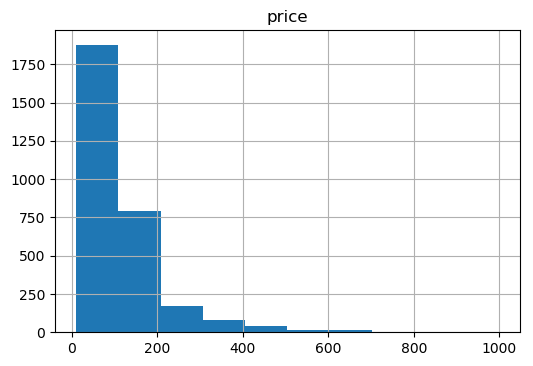

In [144]:
project_df.hist('price');

**Log_price feature created and calculated. log_price is the response variable

In [65]:
project_df['log_price'] = np.log(project_df['price'])
project_df.sample()

,bCls,dist,frDvy,insBk,airpt,trips,rvs,id,city,latitude,longitude,state,price,AT,make,model,year,sold,type_car,type_minivan,type_suv,type_truck,type_van,age,log_price
14126,False,9,False,True,False,20,18,306630,Decatur,33.740436,-84.228331,GA,75.0,True,Nissan,Versa,2016,11990.0,1,0,0,0,0,2,4.317488


**Distribution of log_price is more normally distributed and more effective for building linear regression model.

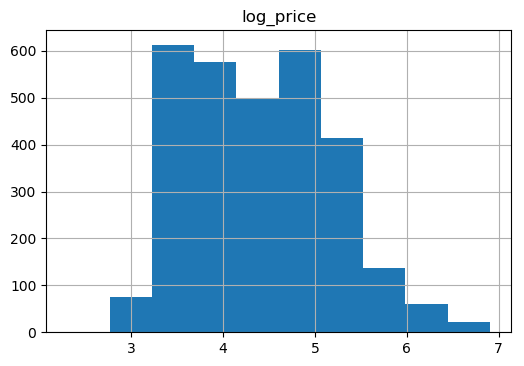

In [145]:
project_df.hist('log_price');

In [39]:
project_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2999 entries, 7 to 36518
Data columns (total 24 columns):
bCls            2999 non-null bool
dist            2999 non-null int64
frDvy           2999 non-null bool
insBk           2999 non-null bool
airpt           2999 non-null bool
trips           2999 non-null int64
rvs             2999 non-null int64
id              2999 non-null int64
city            2999 non-null object
latitude        2999 non-null float64
longitude       2999 non-null float64
state           2999 non-null object
price           2999 non-null float64
AT              2999 non-null bool
make            2999 non-null object
model           2999 non-null object
year            2999 non-null int64
sold            2999 non-null float64
type_car        2999 non-null uint8
type_minivan    2999 non-null uint8
type_suv        2999 non-null uint8
type_truck      2999 non-null uint8
type_van        2999 non-null uint8
log_price       2999 non-null float64
dtypes: bool(5), fl

**First regression model containing all features except reviews. Reviews dropped due to multicollinearity.

In [66]:
# Create feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('log_price ~ bCls + dist + frDvy + insBk + airpt + trips + AT + sold + age +type_minivan + type_truck + type_suv', data = project_df, return_type="dataframe")


model = sm.OLS(y,X)
# Fit model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     350.2
Date:                Mon, 15 Oct 2018   Prob (F-statistic):               0.00
Time:                        04:41:07   Log-Likelihood:                -2176.0
No. Observations:                2999   AIC:                             4378.
Df Residuals:                    2986   BIC:                             4456.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.8395      0.063     61.268      0.000       3.717       3.962
bCls[T.True]     -0.0073      0.024     -0.301      0.764      -0.055       0.040
frDvy[T.True]     0.0318      0.021      1.497      0.134      -0.010       0.074
insBk[T.True]    -0.0835      0.019     -4.311      0.000      -0.122      -0.046
airpt[T.True]    -0.0074      0.041     -0.179      0.858      -0.088       0.073
AT[T.True]       -0.1368      0.055     -2.478      0.013      -0.245      -0.029
dist              0.0033      0.002      1.822      0.069      -0.000       0.007
trips            -0.0033      0.000     -7.742      0.000      -0.004      -0.002
sold           2.517e-05    4.9e-07     51.341      0.000    2.42e-05    2.61e-05
age              -0.0109      0.004     -2.487      0.013      -0.020      -0.002
type_minivan     -0.1128      0.084     -1.339      0.181      -0.278       0.052
type_truck        0.3670      0.071      5.168      0.000       0.228       0.506
type_suv          0.1025      0.023      4.535      0.000       0.058       0.147
==============================================================================
Omnibus:                      119.183   Durbin-Watson:                   1.448
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              190.053
Skew:                           0.351   Prob(JB):                     5.38e-42
Kurtosis:                       4.014   Cond. No.                     3.39e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.39e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Business Class and airport delivery dropped from the model due to high p-values.

In [67]:
y, X = patsy.dmatrices('log_price ~ dist + frDvy + insBk + trips + AT + sold + age + type_minivan + type_truck + type_suv', data = project_df, return_type="dataframe")

model2 = sm.OLS(y,X)

fit2 = model2.fit()

fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     420.5
Date:                Mon, 15 Oct 2018   Prob (F-statistic):               0.00
Time:                        04:42:26   Log-Likelihood:                -2176.1
No. Observations:                2999   AIC:                             4374.
Df Residuals:                    2988   BIC:                             4440.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.8376      0.062     62.116      0.000       3.716       3.959
frDvy[T.True]     0.0304      0.021      1.459      0.145      -0.010       0.071
insBk[T.True]    -0.0839      0.019     -4.392      0.000      -0.121      -0.046
AT[T.True]       -0.1381      0.055     -2.509      0.012      -0.246      -0.030
dist              0.0035      0.002      2.092      0.037       0.000       0.007
trips            -0.0034      0.000     -7.940      0.000      -0.004      -0.003
sold           2.516e-05    4.9e-07     51.371      0.000    2.42e-05    2.61e-05
age              -0.0106      0.004     -2.466      0.014      -0.019      -0.002
type_minivan     -0.1130      0.084     -1.341      0.180      -0.278       0.052
type_truck        0.3667      0.071      5.168      0.000       0.228       0.506
type_suv          0.1025      0.023      4.537      0.000       0.058       0.147
==============================================================================
Omnibus:                      119.968   Durbin-Watson:                   1.448
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              191.790
Skew:                           0.352   Prob(JB):                     2.26e-42
Kurtosis:                       4.019   Cond. No.                     3.39e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.39e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Residual plot verify absence of heteroscedasticity

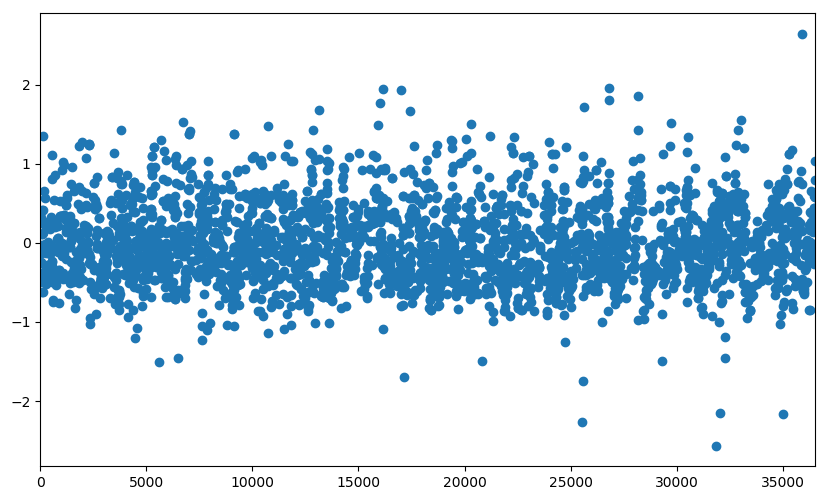

In [146]:
# Use statsmodels to plot the residuals
fit2.resid.plot(style='o', figsize=(10,6));

**Test to determine optimal complexity of the model.

In [69]:
reg = LinearRegression()
res_cv = {}
res_train = {}
for degree in range(5):
    
    # transforms the data to polynomials
    poly = PolynomialFeatures(degree)
    X1 = poly.fit_transform(X)
    
    # calculates the MSE for CV
    scores = cross_val_score(reg, X1, y, cv=10, scoring='mean_squared_error') # cross val
    res_cv[degree] = np.mean(-scores)
    
    # calculates the MSE for Training Set
    reg.fit(X1,y)
    y_pred = reg.predict(X1)
    res_train[degree] = np.sum((y_pred-y)**2)/len(y)
    

**Second-degree polynomial produced the lowest mean-squared-error

The degree 2 had an MSE of: 0.176487067823


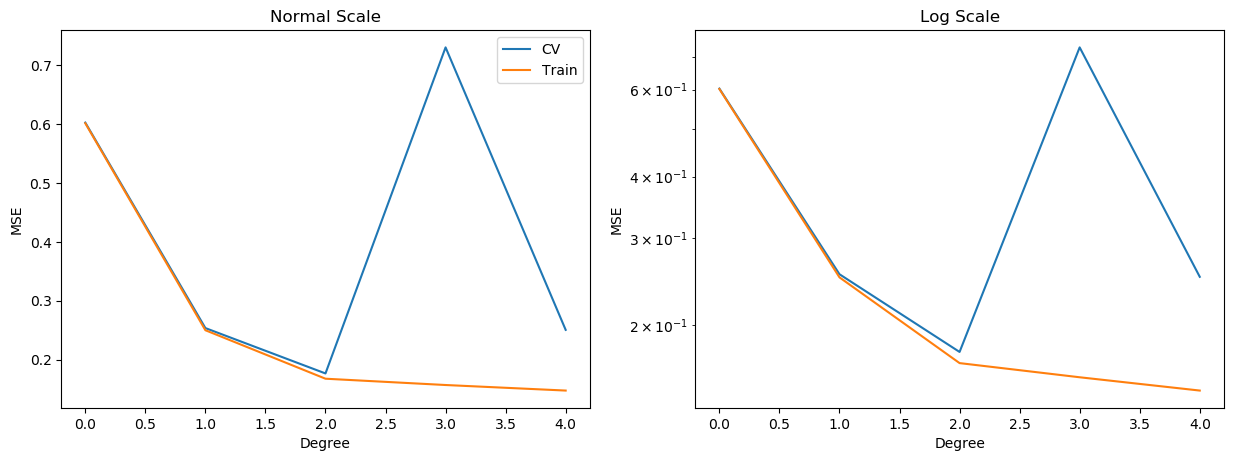

In [147]:
degrees = list(res_cv.keys())
mse_cv = list(res_cv.values())
mse_train = list(res_train.values())

plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
plt.plot(degrees,mse_cv)
plt.plot(degrees,mse_train)
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.title('Normal Scale')
plt.legend(['CV','Train'])

plt.subplot(1,2,2)
plt.semilogy(degrees,mse_cv)
plt.semilogy(degrees,mse_train)
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.title('Log Scale')

loc = np.argmin(list(res_cv.values()))
print('The degree',degrees[loc],'had an MSE of:',mse_cv[loc])

In [ ]:
X['dist_sq'] = X['dist']**2
X['trips_sq'] = X['trips']**2
X['age_sq'] = X['age']**2
X.drop('dist',axis=1,inplace=True)

**Cross validation conducted to test if the model is repeatable. The mean R^2 value is 0.580. The mean of MSE is 0.249.

In [131]:
# 10-fold cross-validation 
reg = LinearRegression()
scores = cross_val_score(reg, X, y, cv=10, scoring='r2')

print('Rˆ2 for each cross-val:',scores,'\n')
print('Mean Rˆ2 of all cross vals:',np.mean(scores),'+-',np.std(scores))

Rˆ2 for each cross-val: [ 0.62979726  0.61048445  0.56084826  0.58388428  0.55020611  0.62152903
  0.60322498  0.60602638  0.53192619  0.50364821] 

Mean Rˆ2 of all cross vals: 0.580157513716 +- 0.0396994871998


In [132]:
scores = cross_val_score(reg, X, y, cv=10, scoring='mean_squared_error')

print('Mean for each cross-val:',-scores,'\n')
print('Mean of all cross vals:',np.mean(-scores),'+-',np.std(-scores))

Mean for each cross-val: [ 0.20281363  0.23939087  0.24904484  0.26736161  0.26136161  0.24020155
  0.25883497  0.28527701  0.24360566  0.23883592] 

Mean of all cross vals: 0.248672767044 +- 0.0208254025637


**Plot actual vs predicted log_price

In [89]:
poly = PolynomialFeatures(degree = degrees[loc])
X1 = poly.fit_transform(X)
reg = LinearRegression()
reg.fit(X1,y)
y_pred = reg.predict(X1)

In [101]:
X = np.array(X)

In [102]:
X = np.squeeze(X)

In [107]:
X

array([[  1.,   1.,   1., ...,   0.,   1.,  36.],
       [  1.,   0.,   1., ...,   0.,  81.,   0.],
       [  1.,   0.,   1., ...,   0.,  81.,   0.],
       ..., 
       [  1.,   0.,   1., ...,   0.,   0.,   1.],
       [  1.,   1.,   0., ...,   1.,   0.,   4.],
       [  1.,   1.,   0., ...,   1.,  36.,  36.]])

In [105]:
y_pred = np.squeeze(y_pred)

In [106]:
y_pred

array([ 3.6233916 ,  4.89129655,  4.89129655, ...,  6.13952795,
        5.36198937,  4.63289025])

In [112]:
y =np.array(y)

In [114]:
y = np.squeeze(y)

In [115]:
y

array([ 3.33220451,  4.94164242,  4.94164242, ...,  6.23048145,
        6.32076829,  4.33073334])

Text(0.5,1,'Actual vs Predicted')

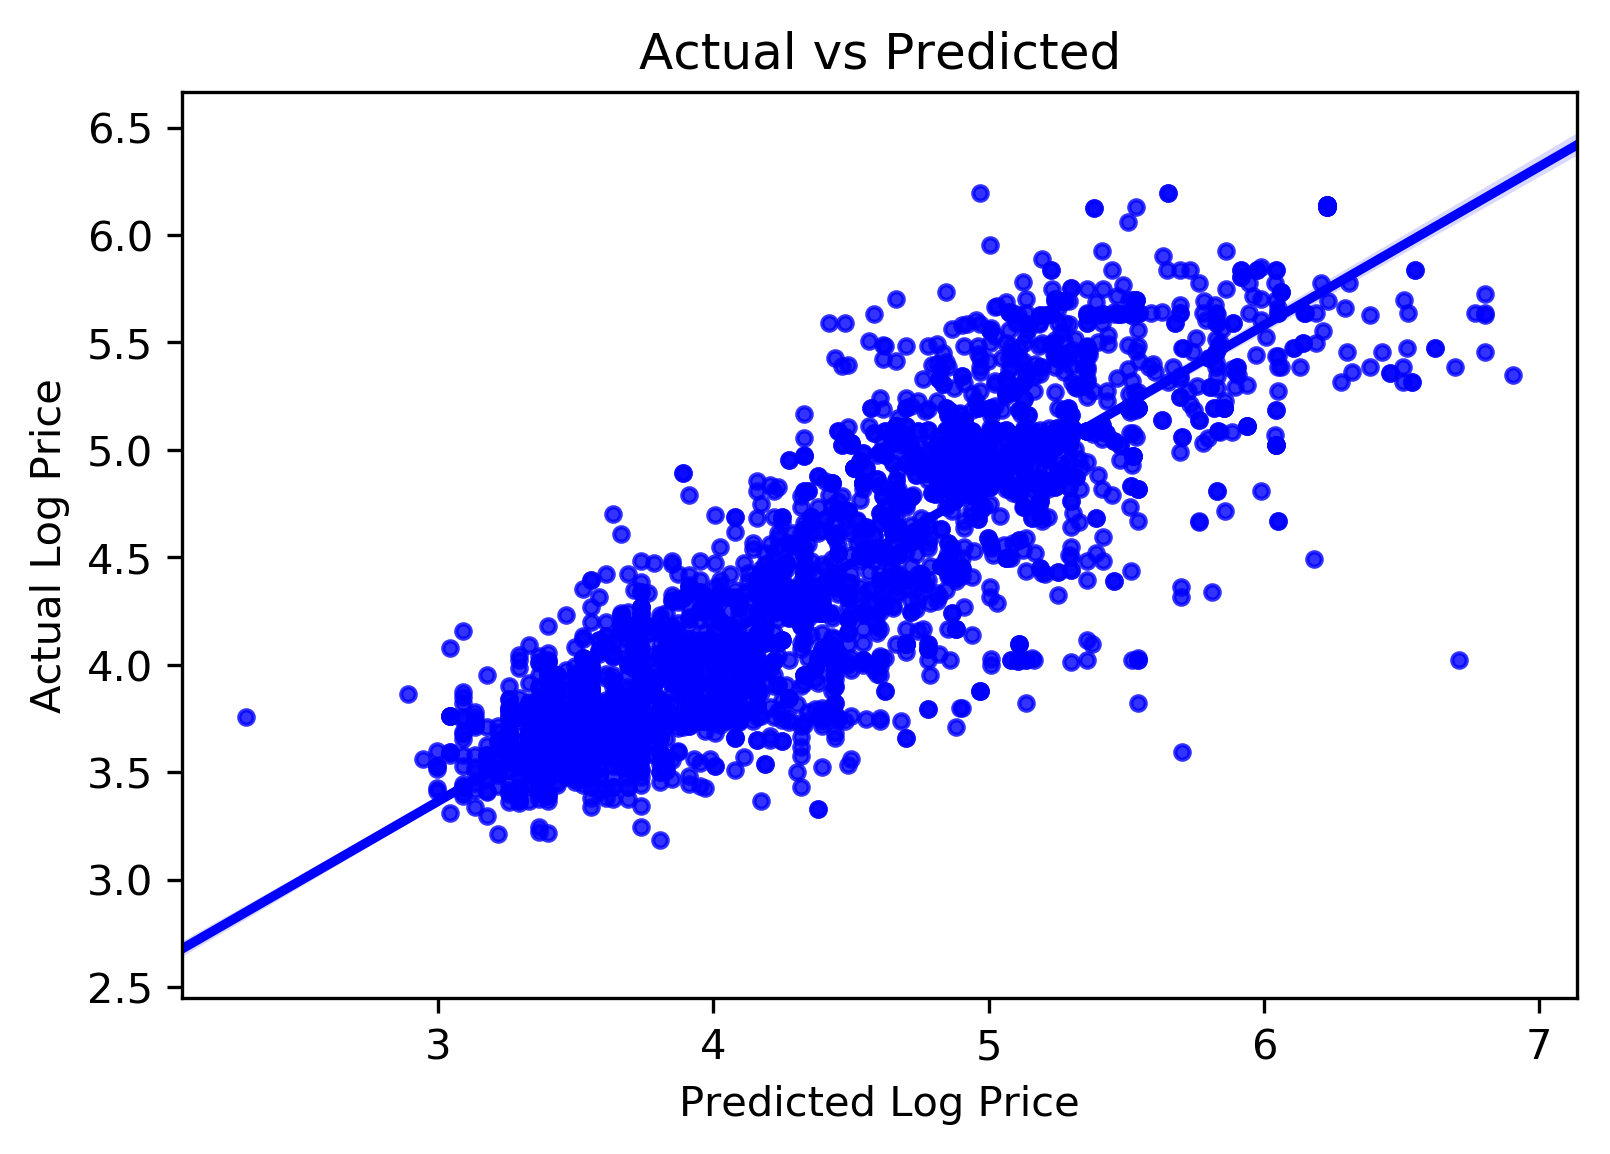

In [128]:
ax = sns.regplot(y, y_pred, color="b",scatter_kws={'s':12})
ax.set_xlabel("Predicted Log Price")
ax.set_ylabel("Actual Log Price")
ax.set_title("Actual vs Predicted")

**The following code takes the exponential of the model to transform the the response variable "log_price" back to "price."
For informational purposes of translating the results to dollars for communication and presentation.

In [129]:
xx = np.exp(y_pred)
yy = np.exp(y)

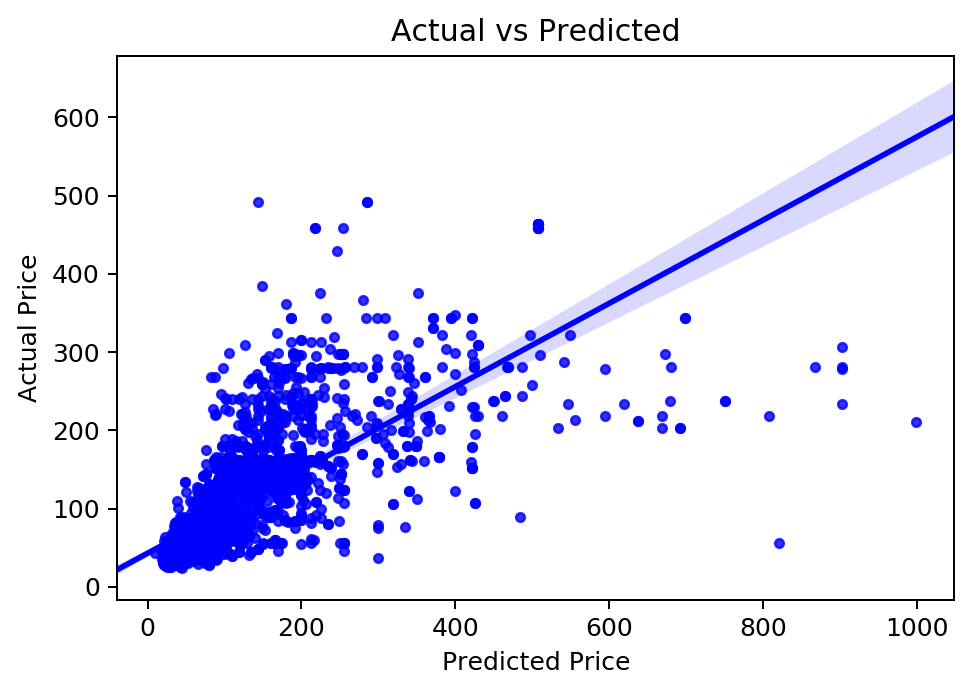

In [152]:
ax = sns.regplot(yy, xx, color="b",scatter_kws={'s':12})
ax.set_xlabel("Predicted Price")
ax.set_ylabel("Actual Price")
ax.set_title("Actual vs Predicted");